# PBN optimizer example
This is an example of the probabilistic Boolean network parameter optimization functionality in KGBN.

In [1]:
import sys
import time
import pandas as pd
import numpy as np
# import booleanNetwork module from ./src
sys.path.append('./src')
from KGBN import PBN, BMatrix
from KGBN.steady_state import SteadyStateCalculator
from KGBN.experiment_data import ExperimentData
from KGBN.parameter_optimizer import ParameterOptimizer

In [2]:
# load the network to be optimized
# pbn = BMatrix.load_pbn_from_file('../input_files/Trairatphisan2014_case3.txt')
string = """
TGFa = 1
TNFa = 1
Raf = TGFa, 1
PI3K = TGFa, 1
Akt = PI3K
C8 = TNFa
NFkB = PI3K, 0.5
NFkB = TNFa, 0.5
ERK = Raf, 0.5
ERK = NFkB, 0.5
"""
pbn = BMatrix.load_pbn_from_string(string)
pbn.nodeDict

No initial state provided, using a random initial state


{'TGFa': 0,
 'TNFa': 1,
 'Raf': 2,
 'PI3K': 3,
 'Akt': 4,
 'C8': 5,
 'NFkB': 6,
 'ERK': 7}

# Load network and experimental data

The example input data is from Trairatphisan et al. 2014:
<img src=./data/Trairatphisan2014_case3.png width="400" height="300" />

In [3]:
# show the input csv format
data = pd.read_csv('./data/Trairatphisan2014_case3.csv')
data.head()

,Experiments,Stimuli,Stimuli_efficacy,Inhibitors,Inhibitors_efficacy,Measured_nodes,Measured_values
0,1,TGFa,NaN,TNFa,NaN,"NFkB,ERK,C8,Akt","0.7,0.88,0,1"
1,2,TNFa,NaN,TGFa,NaN,"NFkB,ERK,C8,Akt","0.3,0.12,1,0"
2,3,"TGFa,TNFa",NaN,NaN,NaN,"NFkB,ERK,C8,Akt","1,1,1,1"
3,4,"TGFa,TNFa",NaN,PI3K,0.7,"NFkB,ERK,C8,Akt","0.51,0.804,1,0.3"
4,5,"TGFa,TNFa",NaN,Raf,0.8,"NFkB,ERK,C8,Akt","1,0.52,1,1"


In [2]:
# load the experiment data
experiments = ExperimentData.load_from_csv('./data/Trairatphisan2014_case3.csv')
experiments

[{'id': 1,
  'stimuli': ['TGFa'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['TNFa'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'NFkB': 0.7, 'ERK': 0.88, 'C8': 0.0, 'Akt': 1.0}},
 {'id': 2,
  'stimuli': ['TNFa'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['TGFa'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'NFkB': 0.3, 'ERK': 0.12, 'C8': 1.0, 'Akt': 0.0}},
 {'id': 3,
  'stimuli': ['TGFa', 'TNFa'],
  'stimuli_efficacy': [1.0, 1.0],
  'inhibitors': [],
  'inhibitors_efficacy': [],
  'measurements': {'NFkB': 1.0, 'ERK': 1.0, 'C8': 1.0, 'Akt': 1.0}},
 {'id': 4,
  'stimuli': ['TGFa', 'TNFa'],
  'stimuli_efficacy': [1.0, 1.0],
  'inhibitors': ['PI3K'],
  'inhibitors_efficacy': [0.7],
  'measurements': {'NFkB': 0.51, 'ERK': 0.804, 'C8': 1.0, 'Akt': 0.3}},
 {'id': 5,
  'stimuli': ['TGFa', 'TNFa'],
  'stimuli_efficacy': [1.0, 1.0],
  'inhibitors': ['Raf'],
  'inhibitors_efficacy': [0.8],
  'measurements': {'NFkB': 1.0, 'ERK': 0.52, 'C8': 1.0, 'Akt': 1.0}},
 {'id': 6,
  's

In [4]:
# get the experiment summary
ExperimentData.get_experiment_summary(experiments)

{'num_experiments': 6,
 'unique_stimuli': ['TGFa', 'TNFa'],
 'unique_inhibitors': ['Raf', 'TGFa', 'PI3K', 'TNFa'],
 'unique_measured_nodes': ['C8', 'ERK', 'NFkB', 'Akt'],
 'value_ranges': {'NFkB': {'min': 0.3, 'max': 1.0},
  'ERK': {'min': 0.12, 'max': 1.0},
  'C8': {'min': 0.0, 'max': 1.0},
  'Akt': {'min': 0.0, 'max': 1.0}},
 'stimuli_efficacy_ranges': {'TGFa': {'min': 1.0, 'max': 1.0},
  'TNFa': {'min': 1.0, 'max': 1.0}},
 'inhibitors_efficacy_ranges': {'TNFa': {'min': 1.0, 'max': 1.0},
  'TGFa': {'min': 1.0, 'max': 1.0},
  'PI3K': {'min': 0.7, 'max': 0.7},
  'Raf': {'min': 0.8, 'max': 0.8}}}

# Simulate the network before optimization

In [6]:
# This is the default network
# Experiment 1: TGFa = 1, TNFa = 0, PI3K = 0 with 70% efficacy
calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['TGFa','TNFa'],inhibitors=['PI3K'],inhibitors_efficacy=[0.7])
calc.compute_steady_state(method='monte_carlo',n_runs=10,n_steps=10000,p_noise=0.05)

array([1.        , 1.        , 0.95132973, 0.32117576, 0.33955209,
       0.95062987, 0.64473105, 0.76828634])

In [7]:
calc.compute_steady_state(method='tsmc',r=0.01,initial_nsteps=100,max_iterations=5000)

array([1.        , 1.        , 0.99883748, 0.29900023, 0.3000465 ,
       0.99953499, 0.65182516, 0.82631946])

# Partical swarm optimization

In [5]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 40,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': - np.inf # early stop disabled
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.001, # range of transition probability [Default=0.001]
                'r': 0.02, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.95, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 5000 # maximum convergence iterations [Default=5000]
            },
    },
    'max_try': 1,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.01 # threshold for accepting fit
}

In [9]:
# Initialize optimizer
optimizer = ParameterOptimizer(pbn, './data/Trairatphisan2014_case3.csv', config=config, nodes_to_optimize=['NFkB','ERK'])

# Run optimization
start_time = time.time()
result = optimizer.optimize(method='particle_swarm')
end_time = time.time()
print(f"Optimization took {end_time - start_time:.2f} seconds")

2025-06-26 13:51:00,799 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 1

--- Attempt 1/1 ---


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.000126
2025-06-26 15:26:54,732 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00012558968979802453, best pos: [0.63586124 0.27103265 0.76631473 0.50805163]



Successful optimization found in attempt 1
  - SSE: 0.000126

--- Optimization finished. Best SSE found: 0.000126 ---

--- Optimized PBN Rules ---
TGFa = 1, 1.0000
TNFa = 1, 1.0000
Raf = TGFa, 1.0000
PI3K = TGFa, 1.0000
Akt = PI3K, 1.0000
C8 = TNFa, 1.0000
NFkB = PI3K, 0.7011
NFkB = TNFa, 0.2989
ERK = Raf, 0.6013
ERK = NFkB, 0.3987
---------------------------


--- Node Deltas (Steady-State vs Measurements) ---

Experiment 1:
  Stimuli: ['TGFa'] (efficacy: [1.0])
  Inhibitors: ['TNFa'] (efficacy: [1.0])
    NFkB: Predicted=0.6949, Measured=0.7000, Delta=-0.0051
    ERK: Predicted=0.8740, Measured=0.8800, Delta=-0.0060
    Experiment SSE: 0.000069

Experiment 2:
  Stimuli: ['TNFa'] (efficacy: [1.0])
  Inhibitors: ['TGFa'] (efficacy: [1.0])
    NFkB: Predicted=0.3076, Measured=0.3000, Delta=+0.0076
    ERK: Predicted=0.1300, Measured=0.1200, Delta=+0.0100
    Experiment SSE: 0.000165

Experiment 3:
  Stimuli: ['TGFa', 'TNFa'] (efficacy: [1.0, 1.0])
  Inhibitors: [] (efficacy: [])
    NF

In [10]:
# Print results
print("Optimization Results:")
print(f"Success: {result.success}")
print(f"Final SSE: {result.fun:.6f}")
print(f"Number of iterations: {result.nit}")
print("\nOptimized Rules:")
print(optimizer.get_pbn_rules_string())

Optimization Results:
Success: True
Final SSE: 0.000126
Number of iterations: 1000

Optimized Rules:
TGFa = 1, 1.0000
TNFa = 1, 1.0000
Raf = TGFa, 1.0000
PI3K = TGFa, 1.0000
Akt = PI3K, 1.0000
C8 = TNFa, 1.0000
NFkB = PI3K, 0.7011
NFkB = TNFa, 0.2989
ERK = Raf, 0.6013
ERK = NFkB, 0.3987


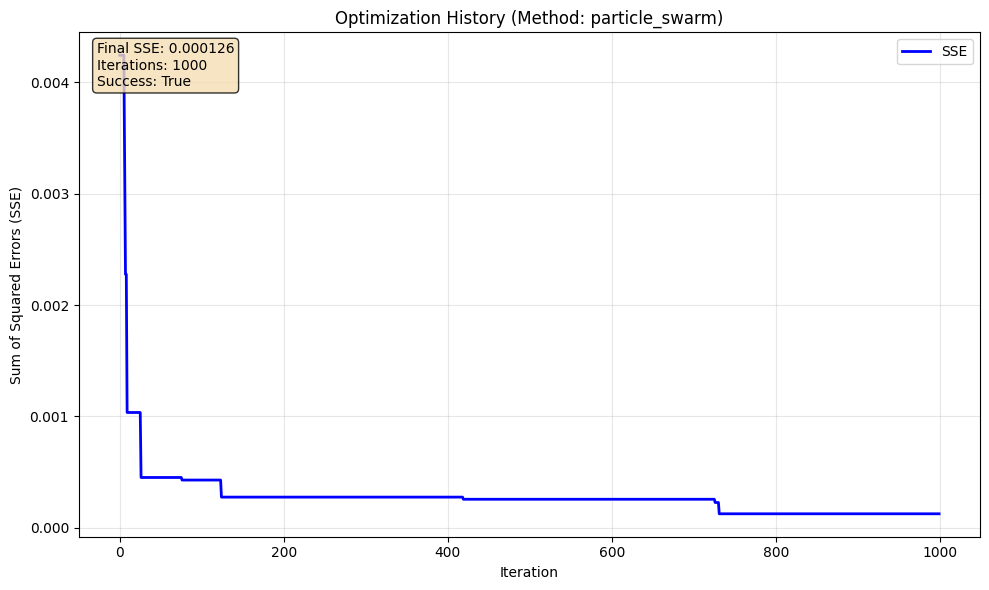

In [11]:
optimizer.plot_optimization_history(result)

## Compare with optPBN

In [3]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 40,  # 20*number of parameters to optimize
        'iters': 200,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': 0.00001, # Function tolerance
        'ftol_iter': 20, # Iterations to check
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.001, # range of transition probability [Default=0.001]
                'r': 0.005, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.95, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 5000 # maximum convergence iterations [Default=5000]
            },
    },
    'max_try': 3,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.00018448,  # An SSE below this is always a success
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
}

In [4]:
# Initialize optimizer
optimizer = ParameterOptimizer(pbn, './data/Trairatphisan2014_case3.csv', config=config, nodes_to_optimize=['NFkB','ERK'], verbose=True)

# Run optimization
start_time = time.time()
result = optimizer.optimize(method='particle_swarm')
end_time = time.time()
print(f"Optimization took {end_time - start_time:.2f} seconds")

2025-07-08 14:01:38,215 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Running optimization using method: particle_swarm
Maximum attempts: 3

--- Attempt 1/3 ---
PSO early stopping enabled:
  - Function tolerance: 1e-05
  - Tolerance iterations: 20


PSO Setup:
  - Particles: 40
  - Max iterations: 200
  - Problem dimensions: 4
  - Total function evaluations: 8000



pyswarms.single.global_best:   0%|          |1/200, best_cost=0.00295

PSO Iteration 1: Current best SSE: 0.002952, Global best SSE: 0.002952


pyswarms.single.global_best:   1%|          |2/200, best_cost=0.00295

PSO Iteration 2: Current best SSE: 0.025379, Global best SSE: 0.002952


pyswarms.single.global_best:   2%|▏         |3/200, best_cost=0.00295

PSO Iteration 3: Current best SSE: 0.005174, Global best SSE: 0.002952


pyswarms.single.global_best:   2%|▏         |4/200, best_cost=0.00295

PSO Iteration 4: Current best SSE: 0.003526, Global best SSE: 0.002952


pyswarms.single.global_best:   2%|▎         |5/200, best_cost=0.00295

PSO Iteration 5: Current best SSE: 0.003927, Global best SSE: 0.002952


pyswarms.single.global_best:   3%|▎         |6/200, best_cost=0.00295

PSO Iteration 6: Current best SSE: 0.003018, Global best SSE: 0.002952


pyswarms.single.global_best:   4%|▎         |7/200, best_cost=0.00295

PSO Iteration 7: Current best SSE: 0.005616, Global best SSE: 0.002952


pyswarms.single.global_best:   4%|▍         |8/200, best_cost=0.00295

PSO Iteration 8: Current best SSE: 0.003240, Global best SSE: 0.002952


pyswarms.single.global_best:   4%|▍         |9/200, best_cost=0.000184

PSO Iteration 9: Current best SSE: 0.000184, Global best SSE: 0.000184


pyswarms.single.global_best:   5%|▌         |10/200, best_cost=0.000184

PSO Iteration 10: Current best SSE: 0.003764, Global best SSE: 0.000184


pyswarms.single.global_best:   6%|▌         |11/200, best_cost=0.000184

PSO Iteration 11: Current best SSE: 0.002294, Global best SSE: 0.000184


pyswarms.single.global_best:   6%|▌         |12/200, best_cost=0.000184

PSO Iteration 12: Current best SSE: 0.018450, Global best SSE: 0.000184


pyswarms.single.global_best:   6%|▋         |13/200, best_cost=0.000184

PSO Iteration 13: Current best SSE: 0.000641, Global best SSE: 0.000184


pyswarms.single.global_best:   7%|▋         |14/200, best_cost=0.000184

PSO Iteration 14: Current best SSE: 0.002759, Global best SSE: 0.000184


pyswarms.single.global_best:   8%|▊         |15/200, best_cost=0.000184

PSO Iteration 15: Current best SSE: 0.003183, Global best SSE: 0.000184


pyswarms.single.global_best:   8%|▊         |16/200, best_cost=0.000184

PSO Iteration 16: Current best SSE: 0.002119, Global best SSE: 0.000184


pyswarms.single.global_best:   8%|▊         |17/200, best_cost=0.000184

PSO Iteration 17: Current best SSE: 0.005992, Global best SSE: 0.000184


pyswarms.single.global_best:   9%|▉         |18/200, best_cost=0.000184

PSO Iteration 18: Current best SSE: 0.003256, Global best SSE: 0.000184


pyswarms.single.global_best:  10%|▉         |19/200, best_cost=0.000184

PSO Iteration 19: Current best SSE: 0.005244, Global best SSE: 0.000184


pyswarms.single.global_best:  10%|█         |20/200, best_cost=0.000184

PSO Iteration 20: Current best SSE: 0.000403, Global best SSE: 0.000184


pyswarms.single.global_best:  10%|█         |21/200, best_cost=0.000184

PSO Iteration 21: Current best SSE: 0.002595, Global best SSE: 0.000184


pyswarms.single.global_best:  11%|█         |22/200, best_cost=0.000184

PSO Iteration 22: Current best SSE: 0.001019, Global best SSE: 0.000184


pyswarms.single.global_best:  12%|█▏        |23/200, best_cost=0.000184

PSO Iteration 23: Current best SSE: 0.002001, Global best SSE: 0.000184


pyswarms.single.global_best:  12%|█▏        |24/200, best_cost=0.000184

PSO Iteration 24: Current best SSE: 0.003598, Global best SSE: 0.000184


pyswarms.single.global_best:  12%|█▎        |25/200, best_cost=0.000184

PSO Iteration 25: Current best SSE: 0.000361, Global best SSE: 0.000184


pyswarms.single.global_best:  13%|█▎        |26/200, best_cost=0.000184

PSO Iteration 26: Current best SSE: 0.000548, Global best SSE: 0.000184


pyswarms.single.global_best:  14%|█▎        |27/200, best_cost=0.000184

PSO Iteration 27: Current best SSE: 0.001936, Global best SSE: 0.000184


pyswarms.single.global_best:  14%|█▍        |28/200, best_cost=0.000184

PSO Iteration 28: Current best SSE: 0.001048, Global best SSE: 0.000184


pyswarms.single.global_best:  14%|█▍        |28/200, best_cost=0.000184
2025-07-08 14:44:08,892 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.00018414786623827229, best pos: [0.81250221 0.35592477 0.66047453 0.42290663]


PSO Iteration 29: Current best SSE: 0.000873, Global best SSE: 0.000184
Total time: 2550.68 seconds

Successful optimization found in attempt 1
  - SSE: 0.000184

--- Optimization finished. Best SSE found: 0.000184 ---

--- Optimized PBN Rules ---
TGFa = 1, 1.0000
TNFa = 1, 1.0000
Raf = TGFa, 1.0000
PI3K = TGFa, 1.0000
Akt = PI3K, 1.0000
C8 = TNFa, 1.0000
NFkB = PI3K, 0.6954
NFkB = TNFa, 0.3046
ERK = Raf, 0.6096
ERK = NFkB, 0.3904
---------------------------

Optimization took 2550.68 seconds


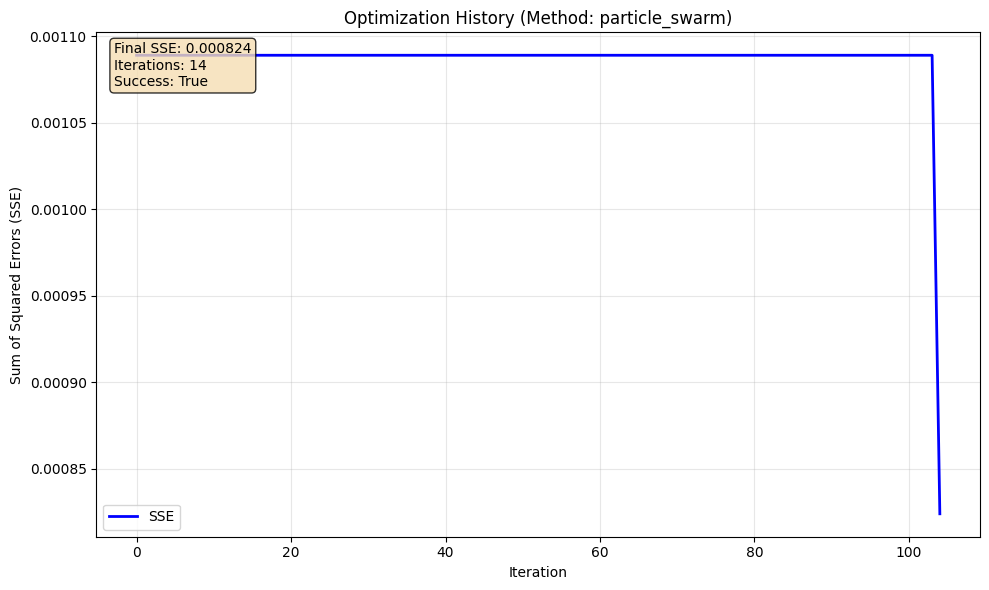

In [5]:
optimizer.plot_optimization_history(result)

# Differential evolution optimization

In [9]:
# Configure optimizer
config = {
    'de_params': {
        'strategy': 'best1bin',
        'maxiter': 5000,
        'popsize': 15,
        'tol': 0.0001, 
        'atol': 0,
        'mutation': (0.5, 1),
        'recombination': 0.7,
        'seed': None,
        'disp': False,
        'init': 'sobol',
        'updating': 'deferred',
        'workers': -1,
        'early_stopping': False  # Control early stopping
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.001, # range of transition probability [Default=0.001]
                'r': 0.025, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.95, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.001, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 5000 # maximum convergence iterations [Default=5000]
            },
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.0001,  # An SSE below this is always a success (global)
    'display_rules_every': 0  # Display optimized rules every n iterations (0 = disabled)
    }

In [10]:
# Initialize optimizer
optimizer = ParameterOptimizer(pbn, './data/Trairatphisan2014_case3.csv', config=config, nodes_to_optimize=['NFkB','ERK'], verbose=False)

# Run optimization
start_time = time.time()
result = optimizer.optimize(method='differential_evolution')
end_time = time.time()
print(f"Optimization took {end_time - start_time:.2f} seconds")


Running optimization using method: differential_evolution
Maximum attempts: 2

--- Attempt 1/2 ---
[██████████████████████████████] 100.0% | Iter: 5000/5000 | Best SSE: 0.000132 | Conv: 0.0005
Total time: 4054.84 seconds
Optimization attempt 1 did not succeed: Maximum number of iterations has been exceeded. (SSE: 0.000176)
Optimized rules: ['NFkB = PI3K, 0.7037', 'NFkB = TNFa, 0.2963', 'ERK = Raf, 0.6006', 'ERK = NFkB, 0.3994']

--- Attempt 2/2 ---
[██████████████████████████████] 100.0% | Iter: 5000/5000 | Best SSE: 0.000302 | Conv: 0.0005
Total time: 3995.90 seconds
Optimization attempt 2 did not succeed: Maximum number of iterations has been exceeded. (SSE: 0.000145)
Optimized rules: ['NFkB = PI3K, 0.7009', 'NFkB = TNFa, 0.2991', 'ERK = Raf, 0.5948', 'ERK = NFkB, 0.4052']

--- Optimization finished. Best SSE found: 0.000145 ---

--- Optimized PBN Rules ---
TGFa = 1, 1.0000
TNFa = 1, 1.0000
Raf = TGFa, 1.0000
PI3K = TGFa, 1.0000
Akt = PI3K, 1.0000
C8 = TNFa, 1.0000
NFkB = PI3K, 0.70